In [2]:
import pandas as pd
import numpy as np

In [3]:
# encounters = pd.read_csv('/data/MIMIC/mini_encounter_vectors_processed.csv') 
encounters = pd.read_csv('/data/MIMIC/encounter_vectors_processed.csv') 
print(encounters.shape)

(1566025, 1200)


In [4]:
from sklearn.preprocessing import MinMaxScaler

# Calculate 6 month and 1 year mortality
encounters['6MONTH'] = 0
encounters['1YEAR'] = 0
encounters.loc[(encounters['SURVIVAL'] > 0) & (encounters['SURVIVAL'] < 183), '6MONTH'] = 1
encounters.loc[(encounters['SURVIVAL'] > 0) & (encounters['SURVIVAL'] < 366), '1YEAR'] = 1
print('Survival :', encounters['6MONTH'].sum(), encounters['1YEAR'].sum())

y_6month = encounters['6MONTH'].values
y_1year = encounters['1YEAR'].values

# drop label columns and convert to numpy
print(type(encounters), encounters.shape)
e = encounters.drop(['SUBJECT_ID', 'HADM_ID', 'ENCOUNTER_ID',
                     'SURVIVAL', '6MONTH', '1YEAR'], axis=1).values
print(type(e), e.shape)

# x = encounters.columns.to_series().groupby(encounters.dtypes).groups
# print(x)

# normalize
x = MinMaxScaler(feature_range=(0, 1), copy=True).fit_transform(e)
print(np.argwhere(np.isnan(x)).shape)

('Survival :', 344049L, 411879L)
(<class 'pandas.core.frame.DataFrame'>, (1566025, 1202))
(<type 'numpy.ndarray'>, (1566025, 1196))
(0, 2)


In [5]:
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras import regularizers
from keras import backend as K

K.set_learning_phase(1)

# add noise, dropout etc.
input_exp = Input(shape=(1196,))
encoded = Dropout(0.2)(input_exp)
encoded = Dense(512, activation='sigmoid')(encoded)
encoded = Dense(256, activation='sigmoid')(encoded)
encoded = Dense(128, activation='sigmoid')(encoded)
encoded = Dense(64, activation='sigmoid')(encoded)
encoded = Dense(128, activation='sigmoid')(encoded)
decoded = Dense(256, activation='sigmoid')(encoded)
decoded = Dense(512, activation='sigmoid')(decoded)
decoded = Dense(1196, activation='sigmoid')(decoded)

autoencoder = Model(input_exp, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(x, x,
                batch_size=256,
                epochs=5,
                shuffle=True)

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.
Epoch 1/5
1566025/1566025 [==============================] - 137s - loss: 0.0610   
Epoch 2/5
1566025/1566025 [==============================] - 118s - loss: 0.0569   
Epoch 3/5
1566025/1566025 [==============================] - 136s - loss: 0.0569   
Epoch 4/5
1566025/1566025 [==============================] - 129s - loss: 0.0569   
Epoch 5/5
1566025/1566025 [==============================] - 135s - loss: 0.0568   


In [6]:
# access hidden layers and visualize
K.set_learning_phase(0)
autoencoder.summary()

# number of samples to plot
plot_num = 1000
get_encoding = K.function([autoencoder.layers[0].input],
                          [autoencoder.layers[5].output])
encoding = get_encoding([x[:plot_num]])[0]
print(encoding.shape)
K.set_learning_phase(1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1196)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1196)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               612864    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               8320      
__________

In [7]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

tsne_model = TSNE(n_components=2, random_state=0)
tsne_out = tsne_model.fit_transform(encoding) 

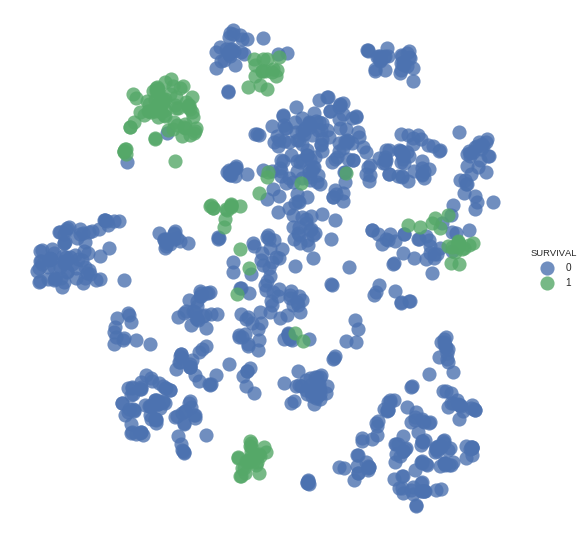

In [8]:
import matplotlib.pyplot as plt

%matplotlib inline
sns.set_style("whitegrid")

# overlay SURVIVAL
df = pd.DataFrame(tsne_out, columns=["x", "y"])
df['SURVIVAL'] = y_1year[:plot_num]

g = sns.lmplot(x="x", y="y", hue='SURVIVAL', size= 8, 
               data=df, fit_reg=False, scatter_kws={"s": 200})
g.set(yticks=[], xticks=[], xlabel='', ylabel='')
sns.despine(left=True, bottom=True)

In [9]:
import pickle as pkl

K.set_learning_phase(0)

batch_size = 10000
batches = (x.shape[0]/batch_size) + 1
print(batches)

print('add to encoding 100k at a time')
all_encoding = []
get_encoding = K.function([autoencoder.layers[0].input],
                          [autoencoder.layers[5].output])
for i in range(batches):
    start = i * batch_size
    end = (i + 1) * batch_size 
    
    all_encoding.extend(get_encoding([x[start:end]])[0])
    print(len(all_encoding))
    
pkl.dump(all_encoding, open('/data/MIMIC/encoding.p', 'wb'))
K.set_learning_phase(1)

157
add to encoding 100k at a time
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000
1010000
1020000
1030000
1040000
1050000
1060000
1070000
1080000
1090000
1100000
1110000
1120000
1130000
1140000
1150000
1160000
1170000
1180000
1190000
1200000
1210000
1220000
1230000
1240000
1250000
1260000
1270000
1280000
1290000
1300000
1310000
1320000
1330000
1340000
1

In [10]:
# pick one more phenotype
import pickle as pkl
all_encoding = pkl.load(open('/data/MIMIC/encoding.p', 'rb'))
encoded_redo = []
for e in all_encoding:
    encoded_redo.extend(e)
print(len(encoded_redo))

100225600


In [ ]:
pkl.dump(encoded_redo, open('/data/MIMIC/encoding.p', 'wb'))